# 第三週：Tidy Data & Tidy Text Processing in Chinese corpus
**Author:** 張芳瑜<br>
**Date created:** 2021/09/21<br>
**Last modified:** 2020/09/21<br>

In [1]:
import pandas# pip install pandas
import jieba # pip install jieba
import jieba.analyse
import pandas as pd
import re
from wordcloud import WordCloud # pip install wordcloud
import matplotlib.pyplot as plt

In [2]:
# 設定圖的字體
plt.rcParams['font.size'] = 14
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 文字處理基本流程
+ step1: 透過論壇、新聞網得到「非結構化」文字資料
+ step2: 將文字內容轉為正規的語句，例如：去除特定符號
+ step3: 將文字內容斷詞斷句
+ step4: 去除停用字(與分析無關的詞彙)，例如：語助詞
+ step5: 根據需求產生不同結構化資料(Tidy Data)
+ step6: 進行不同的分析，例如：情緒分析、詞頻分析

### 建立文本

In [3]:
chinese_text = "近幾年來「良心投資」逐漸形成一股風潮，投資人對於企業社會責任愈來愈重視，環境保護、社會責任與公司治理加總的ESG概念，也成為當今華爾街和法人投資圈最熱門的熱搜關鍵英文縮寫。什麼是「ESG」？就是環境保護（Environmental）、社會責任（Social）與公司治理（Governance）這3個英文字的縮寫，從政府推動限塑政策、上市公司需編製與申報企業社會責任報告書、民間團體自動發起淨灘活動等，背後都蘊含著ESG的意涵。ESG投資可以回溯到2006年聯合國責任投資原則（UNPRI）的成立，致力於推動全球各大投資機構在投資決策過程中必須納入ESG因子，並協助PRI的簽署國家全面提升責任投資的能力。戮力經營本業的企業，若不重視ESG，就算有好的本益比、好的成長，也會影響公司價值，尤其是近年來環境變遷等「無差別衝擊」影響企業經營表現，投資人轉向從ESG、SDGs（聯合國永續發展目標）等評價模式尋找投資標的。"

### 斷詞引擎設定：使用 Jieba 當作斷詞系統

In [4]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt
jieba.set_dictionary('./data/dict.txt') 

# 載入自定義辭典：一個詞一行，每行分詞語、詞頻(可省)、詞性(可省)
jieba.load_userdict('./data/user_dict.txt')

# 參數形式手動加入字詞
words = ['良心投資','投資圈','熱搜','公司治理']
for w in words:
    jieba.add_word(w, freq=None, tag=None)


Building prefix dict from /home/syhwang/SMA/week3_tidy_data/data/dict.txt ...
Dumping model to file cache /tmp/jieba.u6146ce17262a580d0a036503faf370f5.cache
Loading model cost 0.402 seconds.
Prefix dict has been built successfully.


### 進行斷詞

In [5]:
token_list = jieba.lcut(chinese_text)
print(token_list)

['近幾年來', '「', '良心投資', '」', '逐漸', '形成', '一股', '風潮', '，', '投資人', '對於', '企業社會責任', '愈來愈', '重視', '，', '環境', '保護', '、', '社會責任', '與', '公司治理', '加總', '的', 'ESG', '概念', '，', '也', '成為', '當今', '華爾街', '和', '法人', '投資圈', '最', '熱門', '的', '熱搜', '關鍵', '英文', '縮寫', '。', '什麼', '是', '「', 'ESG', '」', '？', '就是', '環境', '保護', '（', 'Environmental', '）', '、', '社會責任', '（', 'Social', '）', '與', '公司治理', '（', 'Governance', '）', '這', '3', '個', '英文字', '的', '縮寫', '，', '從', '政府', '推動', '限塑', '政策', '、', '上市', '公司', '需', '編製', '與', '申報', '企業社會責任', '報告書', '、', '民間', '團體', '自動', '發起', '淨灘', '活動', '等', '，', '背後', '都', '蘊含', '著', 'ESG', '的', '意涵', '。', 'ESG', '投資', '可以', '回溯到', '2006', '年', '聯合國', '責任', '投資', '原則', '（', 'UNPRI', '）', '的', '成立', '，', '致力', '於', '推動', '全球', '各大', '投資', '機構', '在', '投資', '決策', '過程', '中', '必須', '納入', 'ESG', '因子', '，', '並', '協助', 'PRI', '的', '簽署', '國家', '全面', '提升', '責任', '投資', '的', '能力', '。', '戮力', '經營', '本業', '的', '企業', '，', '若', '不', '重視', 'ESG', '，', '就算', '有', '好', '的', '本益比', '、', '好', '的', '成長'

### 移除停用字（無意義的字、標點符號）

In [6]:
# 匯入檔案形式
stopwords = []

#匯入檔案
with open(f'./data/text_stopwords.txt','r') as f:
    stopwords = f.read().splitlines() #移除換行符號\n

# 參數形式手動加入停用字
user_stop = ["的", "來", "對於", "愈來愈", "就是", "什麼"]
for i in user_stop:
    stopwords.append(i)

print(stopwords)


['，', '「', '」', '、', '。', '？', '（', '）', '"', '的', '來', '對於', '愈來愈', '就是', '什麼']


### 篩選掉token_list裡的停用字

In [7]:
doc_tokens = list(filter(lambda x : x not in stopwords, token_list))
print(doc_tokens)

['近幾年來', '良心投資', '逐漸', '形成', '一股', '風潮', '投資人', '企業社會責任', '重視', '環境', '保護', '社會責任', '與', '公司治理', '加總', 'ESG', '概念', '也', '成為', '當今', '華爾街', '和', '法人', '投資圈', '最', '熱門', '熱搜', '關鍵', '英文', '縮寫', '是', 'ESG', '環境', '保護', 'Environmental', '社會責任', 'Social', '與', '公司治理', 'Governance', '這', '3', '個', '英文字', '縮寫', '從', '政府', '推動', '限塑', '政策', '上市', '公司', '需', '編製', '與', '申報', '企業社會責任', '報告書', '民間', '團體', '自動', '發起', '淨灘', '活動', '等', '背後', '都', '蘊含', '著', 'ESG', '意涵', 'ESG', '投資', '可以', '回溯到', '2006', '年', '聯合國', '責任', '投資', '原則', 'UNPRI', '成立', '致力', '於', '推動', '全球', '各大', '投資', '機構', '在', '投資', '決策', '過程', '中', '必須', '納入', 'ESG', '因子', '並', '協助', 'PRI', '簽署', '國家', '全面', '提升', '責任', '投資', '能力', '戮力', '經營', '本業', '企業', '若', '不', '重視', 'ESG', '就算', '有', '好', '本益比', '好', '成長', '也', '會', '影響', '公司', '價值', '尤其', '是', '近年', '環境', '變遷', '等', '無', '差別', '衝擊', '影響', '企業', '經營', '表現', '投資人', '轉向', '從', 'ESG', 'SDGs', '聯合國', '永續', '發展', '目標', '等', '評價', '模式', '尋找', '投資', '標的']


### 可篩選條件：假如字詞長度小於二則不納入

In [8]:
doc_tokens = list(filter(lambda x : len(x)>=2, token_list))
print(doc_tokens)

['近幾年來', '良心投資', '逐漸', '形成', '一股', '風潮', '投資人', '對於', '企業社會責任', '愈來愈', '重視', '環境', '保護', '社會責任', '公司治理', '加總', 'ESG', '概念', '成為', '當今', '華爾街', '法人', '投資圈', '熱門', '熱搜', '關鍵', '英文', '縮寫', '什麼', 'ESG', '就是', '環境', '保護', 'Environmental', '社會責任', 'Social', '公司治理', 'Governance', '英文字', '縮寫', '政府', '推動', '限塑', '政策', '上市', '公司', '編製', '申報', '企業社會責任', '報告書', '民間', '團體', '自動', '發起', '淨灘', '活動', '背後', '蘊含', 'ESG', '意涵', 'ESG', '投資', '可以', '回溯到', '2006', '聯合國', '責任', '投資', '原則', 'UNPRI', '成立', '致力', '推動', '全球', '各大', '投資', '機構', '投資', '決策', '過程', '必須', '納入', 'ESG', '因子', '協助', 'PRI', '簽署', '國家', '全面', '提升', '責任', '投資', '能力', '戮力', '經營', '本業', '企業', '重視', 'ESG', '就算', '本益比', '成長', '影響', '公司', '價值', '尤其', '近年', '環境', '變遷', '差別', '衝擊', '影響', '企業', '經營', '表現', '投資人', '轉向', 'ESG', 'SDGs', '聯合國', '永續', '發展', '目標', '評價', '模式', '尋找', '投資', '標的']


## 進行實際應用前，先介紹 Tidy Data
> 分析前要將資料整理成方便分析的格式，主要有幾個原則：
> <br>
> + 每個變數分別在個別的欄位。
> + 每筆觀察值形成一列。
> + 不同主題要用不同table來整理。

### 以下表一表二資料相同，但紀錄方式不同
#### 此表有三種變數（person、treatment、result）
<img src="./pic/untidy.png" alt="untidy_table" width="400"/>

### 為了方便分析，將資料轉換為 Tidy Data，變成以下表格
#### 每一欄(column)都是變數(person、treatment、result)，每一列都是觀察值。
<img src="./pic/tidy_table.png" alt="tidy_table" width="400"/>

## 以紅樓夢的文本作為應用：文本自古騰堡取得
+ [古騰堡網站 Gutenberg](https://www.gutenberg.org/)
+ [紅樓夢 in Gutenberg](https://www.gutenberg.org/ebooks/24264)

In [9]:
# 古騰堡下載紅樓夢文本 https://www.gutenberg.org/files/24264/24264-0.txt
# 將下載的txt檔讀入
with open(f'./data/red_content.txt', 'r', encoding='UTF-8-sig') as f:
    data = f.read().splitlines()

data[:10]

['第一回\u3000甄士隱夢幻識通靈\u3000賈雨村風塵怀閨秀',
 '-----------------------------------------------------------------',
 '此開卷第一回也．作者自云：因曾歷過一番夢幻之后，故將真事隱去，',
 '而借"通靈"之說，撰此《石頭記》一書也．故曰"甄士隱"云云．但書中所記',
 '何事何人？自又云：“今風塵碌碌，一事無成，忽念及當日所有之女子，一',
 '一細考較去，覺其行止見識，皆出于我之上．何我堂堂須眉，誠不若彼裙釵',
 '哉？實愧則有余，悔又無益之大無可如何之日也！當此，則自欲將已往所賴',
 '天恩祖德，錦衣紈褲之時，飫甘饜肥之日，背父兄教育之恩，負師友規談之',
 '德，以至今日一技無成，半生潦倒之罪，編述一集，以告天下人：我之罪固',
 '不免，然閨閣中本自歷歷有人，万不可因我之不肖，自護己短，一并使其泯']

### 去除重複的句子、空行清除
+ pandas.unique : 此函式可以刪掉重複資料，並保留資料順序
+ tolist : 將其轉換為list
+ len()>0 : 代表空行會被清除

In [10]:
content = pandas.unique(data).tolist()
content = list(filter(lambda x: len(x)>0 ,content))

### 將資料做成DataFrame : 用 Python dict 建立 DataFrame
+ dict key 對應到 dataframe 的欄位名稱
+ dict value 則對應到 dataframe 的欄位數值

In [11]:

content_df = pd.DataFrame({
    'text':content
})
content_df

,text
0,第一回 甄士隱夢幻識通靈 賈雨村風塵怀閨秀
1,----------------------------------------------...
2,此開卷第一回也．作者自云：因曾歷過一番夢幻之后，故將真事隱去，
3,"而借""通靈""之說，撰此《石頭記》一書也．故曰""甄士隱""云云．但書中所記"
4,何事何人？自又云：“今風塵碌碌，一事無成，忽念及當日所有之女子，一
...,...
27744,飄然而去．一面走著，口中說道：“果然是敷衍荒唐！不但作者不知，抄者不知，
27745,"并閱者也不知．不過游戲筆墨，陶情适性而已！""后人見了這本奇傳，亦曾題過"
27746,四句為作者緣起之言更轉一竿頭云：
27747,說到辛酸處，荒唐愈可悲．


### 判斷章節function
+ 紅樓夢每章開頭都有“第xx回“的詞，有的直接結束、有的後面會加上章回名稱
+ re.search : 搜尋字串直到相符合，假如沒找到則會返回 None
+ Regular Expression : 使用字串('^第.*回(　|$)')來描述「規則」，用以尋找符合的字串
+ 正規式常用工具網站 : [網站連結](https://regex101.com/)
+ 正規式參考教材 : [文字處理的大絕招](http://datascienceandr.org/articles/RegularExpression.html)

In [12]:

def get_chapter(text):
    if re.search('第.*回(　|$)', text) == None:
    #「第」之後接0~無限個任意字元，「回」之後是空格或者結束
        return 0
    else:
        return 1

### 取得章節
+ DataFrame.apply() : 將函式應用到每一列
+ DataFrame.cumsum() : 用於累加值
+ axis=0 : 對橫軸進行操作，運算方向則為縱向運算
+ axis=1 : 對縱向進行操作，運算方向則為橫向運算

In [13]:
content_df['chapter'] = content_df['text'].apply(get_chapter).cumsum(axis=0)
content_df

,text,chapter
0,第一回 甄士隱夢幻識通靈 賈雨村風塵怀閨秀,1
1,----------------------------------------------...,1
2,此開卷第一回也．作者自云：因曾歷過一番夢幻之后，故將真事隱去，,1
3,"而借""通靈""之說，撰此《石頭記》一書也．故曰""甄士隱""云云．但書中所記",1
4,何事何人？自又云：“今風塵碌碌，一事無成，忽念及當日所有之女子，一,1
...,...,...
27744,飄然而去．一面走著，口中說道：“果然是敷衍荒唐！不但作者不知，抄者不知，,120
27745,"并閱者也不知．不過游戲筆墨，陶情适性而已！""后人見了這本奇傳，亦曾題過",120
27746,四句為作者緣起之言更轉一竿頭云：,120
27747,說到辛酸處，荒唐愈可悲．,120


### 設定斷詞引擎，匯入專有詞彙
1. [搜狗引擎](https://pinyin.sogou.com/dict/) : 在此處搜尋專有字典
1. [搜狗詞庫scel轉txt](https://www.toolnb.com/tools-lang-zh-TW/scelto.html) : 將檔案轉換
1. [純文字檔案簡體轉繁體](https://txtconv.arpuli.com/) : 下載字體為簡體，將其轉換成繁體


In [14]:
# 初始化斷詞引擎
jieba.set_dictionary('./data/dict.txt')

# 自定義辭典
jieba.load_userdict('./data/red_dict.text')

Building prefix dict from /home/syhwang/SMA/week3_tidy_data/data/dict.txt ...
Loading model from cache /tmp/jieba.u6146ce17262a580d0a036503faf370f5.cache
Loading model cost 0.305 seconds.
Prefix dict has been built successfully.


### 將斷詞結果存進 DataFrame
+ assign : 新增一個欄位「word」，值為content_df['text']進行jieba.lcut的結果
+ explode : jieba_lcut 的結果為list，因此用explode將list裡的每個值變單獨一行
+ drop : 將欄位「text」刪除，axis=0為對縱軸操作(column)，axis=1為對橫軸操作(row)

In [15]:
word_df = content_df.assign(word = content_df['text'].apply(jieba.lcut)).explode('word').drop(['text'], axis=1)
word_df

,chapter,word
0,1,第一回
0,1,
0,1,甄士隱夢幻識通靈
0,1,
0,1,賈雨村
...,...,...
27748,120,，
27748,120,休笑
27748,120,世人
27748,120,痴


### 移除停用字（空格、標點符號、無意義字...）

In [16]:
# 匯入檔案形式
red_stopwords = []

#匯入檔案
with open(f'./data/stopwords.txt','r') as f:
    red_stopwords = f.read().splitlines() #移除換行符號\n

### 依照條件篩選數據：停用字

In [17]:
# 依照條件選數據：word_df['word']沒有在停用字裡
word_df = word_df[(word_df['word'].isin(red_stopwords) == False)]
word_df

,chapter,word
0,1,第一回
0,1,甄士隱夢幻識通靈
0,1,賈雨村
0,1,風塵
0,1,怀
...,...,...
27748,120,同一
27748,120,夢
27748,120,休笑
27748,120,世人


### 依照條件篩選數據：詞彙出現的次數，例如：詞彙只有一個字不計算
+ loc[] : 用條件來取出資料長度大於1
+ value_count : 用此函式算出每個字的次數，提取其index & values 放進 DataFrame

In [18]:
word_df = word_df.loc[word_df['word'].str.len()>1]
word = word_df.word.value_counts() # 計算「word」這個欄位

freq_df = pd.DataFrame({
    'freq':word.values,
    'word':word.index
})
freq_df

,freq,word
0,3757,寶玉
1,2187,笑道
2,1653,鳳姐
3,1613,賈母
4,1079,什么
...,...,...
47209,1,條盆
47210,1,后務待
47211,1,罷罷罷
47212,1,文房四寶


### 最常見的前10個詞彙

In [19]:
freq_df.head(10)

,freq,word
0,3757,寶玉
1,2187,笑道
2,1653,鳳姐
3,1613,賈母
4,1079,什么
5,1063,姑娘
6,1058,黛玉
7,1057,那里
8,1021,寶釵
9,1002,王夫人


## 繪製文字雲

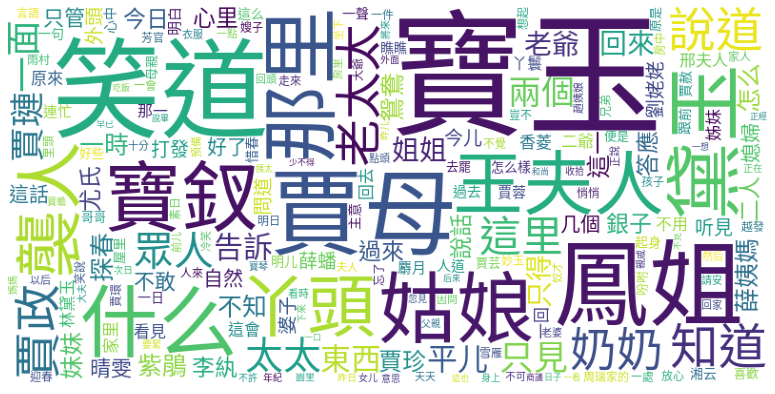

In [20]:

# 詞頻變成dict
freq_dict = freq_df.set_index('word', inplace=False).to_dict()
freq_dict = freq_dict['freq']

# 繪製文字雲
FontPath = './data/SourceHanSansTW-Regular.otf' # 設定字型
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=FontPath, max_words=200)
wordcloud.generate_from_frequencies(freq_dict)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## matplotlib 畫圖中文顯示不出來的問題
+ Mac : [參考方式](https://blog.csdn.net/RivenDong/article/details/118990773)
+ Windows : [參考方式](https://medium.com/marketingdatascience/%E8%A7%A3%E6%B1%BApython-3-matplotlib%E8%88%87seaborn%E8%A6%96%E8%A6%BA%E5%8C%96%E5%A5%97%E4%BB%B6%E4%B8%AD%E6%96%87%E9%A1%AF%E7%A4%BA%E5%95%8F%E9%A1%8C-f7b3773a889b)
+ 暫存查找 path 方式：matplotlib.get_cachedir()

## 繪製長條圖

<AxesSubplot:ylabel='word'>

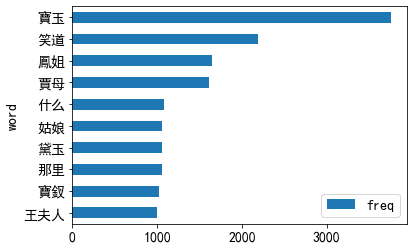

In [21]:

fre_plot = freq_df
fre_plot['freq'].astype(int) #將column轉integer
fre_plot = fre_plot.head(10).sort_values(by='freq', ascending=True)
fre_plot.plot(x='word',kind='barh') #bar垂直 barh水平

## 各章節長度: 繪製成折線圖

In [22]:
chapter_count = pd.DataFrame({
    'chapter': content_df.groupby('chapter').size().index,
    'sentences': content_df.groupby('chapter').size().values,
    'word': word_df.groupby('chapter').size().values,
})
chapter_count

,chapter,sentences,word
0,1,260,2198
1,2,192,1564
2,3,274,2312
3,4,193,1594
4,5,274,2034
...,...,...,...
115,116,163,1324
116,117,220,1691
117,118,220,1797
118,119,279,2289


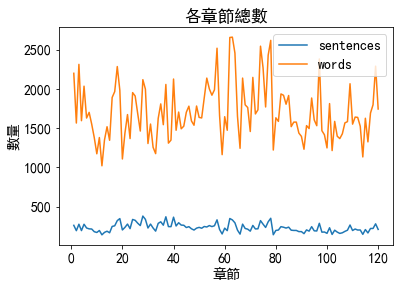

In [23]:
plt.plot(chapter_count['chapter'].values, chapter_count['sentences'].values ,label = 'sentences')
plt.plot(chapter_count['chapter'].values, chapter_count['word'].values, label = 'words')
plt.title('各章節總數') # 標題
plt.xlabel('章節') # x軸標題
plt.ylabel('數量') # y軸標題
plt.legend() # 顯示label
plt.show()

## 比較前80回與後40回的詞彙差異

In [24]:
eighty_fourty = word_df.copy()
eighty_fourty.loc[ eighty_fourty.chapter <= 80, 'part'] = 'First80'
eighty_fourty.loc[ eighty_fourty.chapter > 80, 'part'] = 'Last40'
eighty_fourty

,chapter,word,part
0,1,第一回,First80
0,1,甄士隱夢幻識通靈,First80
0,1,賈雨村,First80
0,1,風塵,First80
0,1,閨秀,First80
...,...,...,...
27747,120,可悲,Last40
27748,120,由來,Last40
27748,120,同一,Last40
27748,120,休笑,Last40


### Pivot Table
+ pandas.pivot_tale( index= , columns= , values= , aggfunc=)
+ index: 必要參數，此處為不想變動的數據，作為比較欄位的索引。(字都一樣，為index)
+ columns: 可選。用以分割數據，選出想比較的欄位。(比較不同part)
+ values: 可選。針對需要的數據做篩選。(取得比例)

In [25]:
# groupby「word」、「part」，計算次數
part_df = pd.DataFrame({
    'n':eighty_fourty.groupby(['word','part']).size(),
})

# 計算比例（除以總次數）
part_df['proportion'] = part_df['n']/sum(part_df['n'])

# pivot_table()
part_df = part_df.pivot_table(index='word', columns='part', values='proportion')
part_df = part_df.sort_values(by='First80', ascending=False)
part_df

part,First80,Last40
word,,
寶玉,0.012497,0.005908
笑道,0.009812,0.000901
鳳姐,0.005717,0.002381
賈母,0.005178,0.002724
黛玉,0.003209,0.001974
...,...,...
龍井茶,NaN,0.000005
龍女,NaN,0.000005
龍池,NaN,0.000005


## 比較詞彙使用習慣

In [26]:
part_df = part_df.reset_index() # 將index reset
part_df = part_df.fillna(0) # 空值補零

In [27]:
part_df['sub_last'] = part_df['First80'] - part_df['Last40'] # 前80回減後40回（前面比較常用，後面不常用）
part_df['sub_first'] = part_df['Last40'] - part_df['First80'] # 後40回減前80回（後面比較常用，前面不常用）
part_df

part,word,First80,Last40,sub_last,sub_first
0,寶玉,0.012497,0.005908,0.006589,-0.006589
1,笑道,0.009812,0.000901,0.008911,-0.008911
2,鳳姐,0.005717,0.002381,0.003336,-0.003336
3,賈母,0.005178,0.002724,0.002454,-0.002454
4,黛玉,0.003209,0.001974,0.001235,-0.001235
...,...,...,...,...,...
47209,龍井茶,0.000000,0.000005,-0.000005,0.000005
47210,龍女,0.000000,0.000005,-0.000005,0.000005
47211,龍池,0.000000,0.000005,-0.000005,0.000005
47212,龍目,0.000000,0.000005,-0.000005,0.000005


## 前80回常用、後40回不常用 vs 後40回常用、前80回不常用

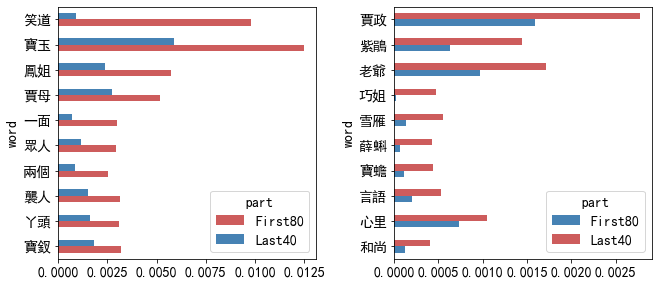

In [28]:
fig, axes = plt.subplots( nrows=1, ncols=2)

sub_last = part_df.sort_values('sub_last', ascending=True).tail(10)
sub_last.plot(x='word', y=['First80', 'Last40'], kind='barh', color=['indianred', 'steelblue'], ax=axes[0])

sub_first = part_df.sort_values('sub_first', ascending=True).tail(10)
sub_first.plot(x='word', y=['First80', 'Last40'], kind='barh', color=['steelblue', 'indianred'], ax=axes[1])

# 控制圖的間距
plt.subplots_adjust(top=1.0,left=0.125,right=1.5,wspace=0.3)

## 前80回與後40回頻率一樣的詞彙

<AxesSubplot:ylabel='word'>

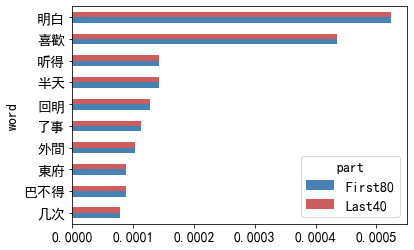

In [29]:
same = part_df[part_df['sub_first'] == 0].head(10).sort_values(by='First80',ascending=True)
same.plot(x='word', y=['First80', 'Last40'], kind='barh', color=['steelblue', 'indianred'])